## 3D Printed Cookie-Cutter Example
- A "Turtle Graphics" approach is used to define the extrusion paths:  A series of `(segment length, change of heading angle)` - tuples defines a path segment. e.g. the tuple `(2*pi ,2*pi)` defines a unit circle, the tuple `(1,0)` a straight line of unit length, and `(0,-30)` turns on the spot `30deg` to the right.
- Print layers are defined as a list of path offsets and extrusion widths:  Each layer has a different `(offset,extrusion width)`-list defined. The result is a "Brickwork" of overlapping extrusions.
- Complex numbers are used for the 2D coordinates:  2D translations and rotations are simple additions and multiplications of complex numbers. E.g. the complex expression `(3+5j)*1j**(30/90)` rotates the point `(x=3,y=5)` counter-clockwise by `30deg` around the origin.

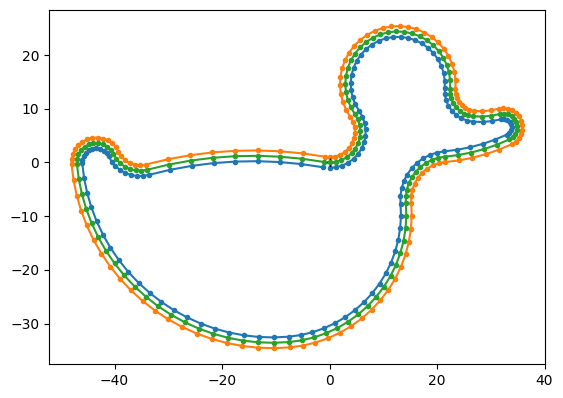

135

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign
deg=pi/180
PlainSegments=[(50,360*deg)]
ScallopedSegments=(lambda n,a:[(1.0,(360/n-a)*deg),(2,a*deg)]*n)(n=9,a=150)
HeartSegments=[(0.45,-45.0*deg),(10.0,180.0*deg),(6.91,-10.0*deg),(1.1,110.0*deg),(6.91,-10.0*deg),(10.0,180.0*deg),(0.45,-45.0*deg)]
StarSegments=(lambda n,a:[(2,-(a-360/n)*deg),(8,0.0),(3.2,a*deg),(8,0.0)]*n)(5,130)
DuckSegments=[(0.4,-10.0*deg),(13.297,25.0*deg),(3,-80.0*deg),(4,160.0*deg),(22.913,90.0*deg),(15,90.0*deg),(5,-90.0*deg), (5,20.0*deg),(3,170.0*deg),(2,-20.0*deg),(3,-90.0*deg),(15,220.0*deg),(5,-125.0*deg),]
TreeSegments=[(0.75,40.0*deg)]+(lambda n,a:[(3,0.0), (1.5,a*deg),(0.6,0.0), (1.0,-a*deg)]*n)(4,140)[:-3]+[(1.5,140.0*deg)]
TreeSegments+=[(12.4-0.969,0)]
TreeSegments+=reversed(TreeSegments[:-1])

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLengthArea(Segs):
  nSegs=len(Segs)
  dl,dang=np.array(Segs).transpose()
  l=sum(dl)
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return l,area

def InterpSegments(Segs,t,p0=0+0j,a0=1+0j,scale=1.0,return_heading=False):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array(Segs).transpose()
  l,ang=np.cumsum(Segs,axis=0).transpose()
  ang=exp(1j*np.insert(ang,0,0))*a0
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(viSeg)+p0
  l=l/l[-1]
  l=np.insert(l,0,0)
  Xx=np.interp(np.array(t)%1,l,range(len(l)))
  X=Xx.astype(int)#segment index
  x=Xx%1#within seggment
  p=pSeg[X-1] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  if not return_heading:
    return p
  else:
    a=ang[X]*np.exp(1j*dang[X]*x)
    return p,a

def Segments2Complex(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,return_heading=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  for l,da in Segs:
    l=l*scale
    if da!=0:
      r=l/da
      r+=offs
      l=r*da
      dl=2*abs(2*r*tol)**0.5
      n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
      dda=exp(1j*da/n)
      dda2=dda**0.5
      v=(2*r*dda2.imag)*dda2*a
    else:
      n=1
      dda=1
      v=l*a
    for _ in range(n):
      p+=v
      if return_heading:
        yield p,a
      else:
        yield p
      v*=dda
      a*=dda

for offs in (-1,1,0):
  px,a=np.array(list(Segments2Complex(DuckSegments,scale=2.5,a0=-1,tol= 0.03,offs=offs,return_heading=True))).transpose()
#  x-=1j*a*offs
  plt.plot(0,0,'k+')
  plt.plot(px.real,px.imag,'.-')
plt.gca().set_aspect('equal')
plt.show()
len(px)

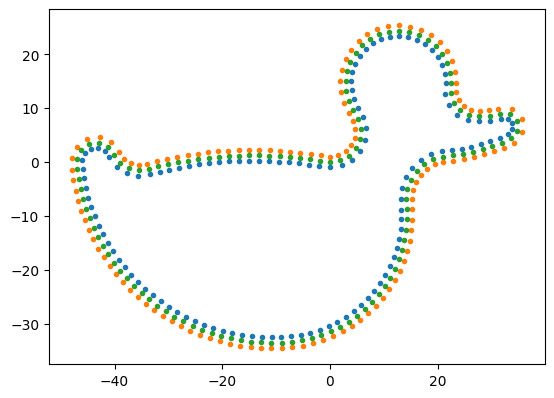

In [ ]:
n=128
t=np.arange(0,1-0.5/n,1/n)#equally spaced
p,a=InterpSegments(DuckSegments,t,a0=-1,scale=2.5,return_heading=True)
for offs in (-1,1,0):
  p1=p-1j*offs*a
  plt.plot(p1.real,p1.imag,'.')
plt.gca().set_aspect('equal');

In [ ]:
def fill(minx,maxx,n):
  w=maxx-minx
  dx=float(w)/n
  x=minx+dx/2
  result=[(x,dx)]
  for i in range(n-1):
    x+=dx
    result.append((x,dx))
  if n>3:
    result=[result[1]]+[result[0]]+result[n-2:]+result[2:n-2]
  return result
Brickwork= [fill(-w2,w2,n) for w2,n in ((3.6/2,4),(4.0/2,5),(4.4/2,6),(4.6/2,5))]+ \
      [((0.0,cw),(-w2+ww/2,ww),(w2-ww/2,ww)) for w2,ww,cw in[ \
        (4.8/2,1.0,1.0),\
        (5.0/2,1.0,0.8),\
        (5.0/2,0.9,0.6)]+\
        [(5.0/2,0.9,0.5)]*2+[\
        (4.8/2,0.9,0.5),\
        (4.6/2,0.9,0.5),\
        (4.4/2,1.0,0.5)]+\
        [(w2,1.0,0.5)for w2 in(4.0/2,3.6/2,3.2/2,2.8/2)]+\
        [(2.4/2,0.9,0.6)]
        ]+\
      [fill(-w2,w2,n) for w2,n in ((2.0/2,2),(1.6/2,3),(1.2/2,2))]+\
      [[(0.0,1.0-0.5*i/50.0)] for i in range(50+1)]


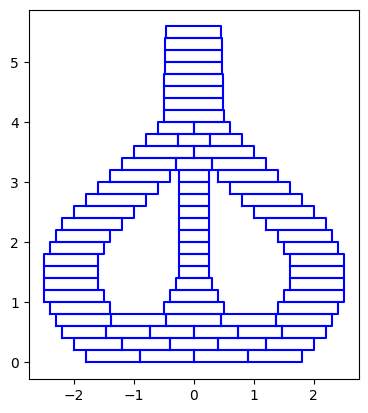

In [ ]:
hl=0.2
for i,layer in enumerate(Brickwork):
    y=i*hl
    if y>5.5:
      break
    for x,w in layer:
      plt.plot((x-w/2,x+w/2,x+w/2,x-w/2,x-w/2),(y,y,y+hl,y+hl,y),'b-')
plt.gca().set_aspect('equal')

In [ ]:
if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
from math import cos, tau

No module named 'fullcontrol'
Attempting to install missing packages. Please wait ...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
steps=[]
Segments=DuckSegments
PathLength,Area=SegmentsLengthArea(Segments)
CookieArea=2000
hl=0.2
BrickworkCrosssectionArea=hl*sum(w for layer in Brickwork for (offs,w) in layer)
scale=(CookieArea/Area)**0.5
Volume=BrickworkCrosssectionArea*PathLength*scale
FilamentDiameter=1.75
tol=0.03
nwipe=5
nskip=5
jt=0
nskirt=2
skirtoffs=3
p0=5-5j
a0=1j**(90/90)
SkirtVolume=hl*0.7*PathLength*scale
print(f'Path length: {PathLength*scale:0,.0f}mm')
print(f'Extruded volume: {Volume:0,.0f}mm^3')
print(f'Estimated filament length ({FilamentDiameter:0.2f}mm diameter): {(Volume+SkirtVolume)/(FilamentDiameter**2/4*np.pi):0,.0f}mm')
for i,layer in enumerate(Brickwork):
    if len(layer)==1:#start of cutting blade: do spiral instead of layers
      break
    z=i*hl
    if i==0:
      layer=[(skirtoffs-(0.6*(i-nskirt)),0.7) for i in range(nskirt)]+layer
    for offs,w in layer:
      path=list(Segments2Complex(Segments,p0=p0,a0=a0,tol=tol,scale=scale,offs=offs))
      n=len(path)
      steps.append(fc.Extruder(on=False))
      steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=hl,width=w))
      jt=jt%n
      p=path[jt]
      steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
      for _ in range(nskip):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=True))
      for _ in range(n):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=False))
      for _ in range(nwipe):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
path=list(Segments2Complex(Segments,p0=p0,a0=a0,tol=tol,scale=scale,offs=offs))
n=len(path)
zb=z
zt=zb+10
dzdj=hl/n
w=layer[0][1]
#print(w)
dwdj=(w-Brickwork[-1][0][1])/(n*(zt-zb)/hl)
old_eh=-1
old_w=-1
steps.append(fc.Extruder(on=True))
#while False:
while  z<(zt+hl):
  jt=(jt+1)%n
  z+=dzdj
  w-=dwdj
  eh=min(z-zb,zt-(z-hl),hl)
  p=path[jt]
  if (abs(eh-old_eh)/hl)>0.01 or abs(w-old_w)>0.005:
   # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
    steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=w))
    old_eh=eh
    old_w=w
  steps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=100, y=100, z=0.0*hl)
#print(f'{w=} {eh=}')
steps = fc.move(steps, model_offset)

Path length: 231mm
Extruded volume: 4,251mm^3
Estimated filament length (1.75mm diameter): 1,781mm


In [ ]:
# add annotations and plot
EW=1.0
EH=0.2
fc.transform(steps, 'plot', fc.PlotControls(color_type='print_sequence', initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#design parameters

design_name = 'cookie_cutter_duck'
nozzle_temp = 220
bed_temp = 120
print_speed = 30*60
fan_percent = 0
EH = 0.2    # extrusion heigth
EW = 0.5    # extrusion width
printer_name = 'generic'
#printer_name = 'Prusa_Mendel'
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)